In [ ]:
import os
import tensorflow as tf
print(tf.__version__)

import matplotlib as plt

import numpy as np
import cv2

from PIL import Image

# Model parameters

In [ ]:
TRAIN_SIZE = 8000
EVAL_SIZE = 2000

# Specify model training parameters.
BATCH_SIZE = 32
EPOCHS = 1000 #Should auto-stop
BUFFER_SIZE = TRAIN_SIZE+BATCH_SIZE


YEARS_PYTHON = ['2003', '2021']
FOLIUMLOCATION = [39.811,-111.625,]

# ALL_BANDS = [f'BGR{i}_median' for i in range(3)]+[f'SWIR{i}_median' for i in range(3)]+[f'SR_TH_median']+\
#                 [f'BGR{i}_diff' for i in range(3)]+[f'SWIR{i}_diff' for i in range(3)]+[f'SR_TH_diff']+\
#                 [f'BGR{i}_stdDev' for i in range(3)]+[f'SWIR{i}_stdDev' for i in range(3)]+[f'SR_TH_stdDev']

All_BANDS = [f'BGR{i}_median' for i in range(3)]
# ALL_BANDS = [f'SWIR{i}_stdDev' for i in range(3)]
# All_BANDS = ['BGR2_median', 'BGR1_median', 'BGR0_median']
# All_BANDS = ['SWIR2_median', 'SWIR2_median', 'SWIR2_median']




KERNEL_SIZE = 256
FOLDER = '/scratch/gza5dr/IrrigationTypeDetection/Experinments/All_NEW/Irrigation_detection/Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_lib7_3_new'
# FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/Oishee_experiments/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_lib7_3'
TRAINING_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_train'
EVAL_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_eval'


import re
BANDS_TO_USE = All_BANDS
        
#RESPONSE = ['Drip', 'Dry Crop', 'Flood', 'Sprinkler'] #Use if drip is to be trained for
#RESPONSE = ['Dry Crop', 'Flood', 'Sprinkler'] 
#RESPONSE = ['Flood', 'Sprinkler'] 
#RESPONSE =['Irrigation']
RESPONSE = ['flood', 'sprinkler', 'other']
#RESPONSE_TO_USE = ['sprinkler']
RESPONSE_TO_USE = RESPONSE

ALL_FEATURES = All_BANDS+RESPONSE
FEATURES_TO_USE = BANDS_TO_USE+RESPONSE_TO_USE



KERNEL_SIZE = 256
FOLDER = '/scratch/gza5dr/IrrigationTypeDetection/Experinments/All_NEW/Irrigation_detection/Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_lib7_3_new'
# FOLDER = '/' + 'project/nwisrl_water/nwisrl_water' + '/Oishee_experiments/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_lib7_3'
TRAINING_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_train'
EVAL_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_eval'

KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in ALL_FEATURES
]
COLUMNS2 = [
  tf.io.FixedLenFeature([], tf.string) for k in ALL_FEATURES
]
ALL_FEATURES_DICT = dict(zip(ALL_FEATURES, COLUMNS))
ALL_FEATURES_DICT_STRING = dict(zip(ALL_FEATURES, COLUMNS2))



# Training Data

In [ ]:
def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  example_message = tf.io.parse_single_example(example_proto, ALL_FEATURES_DICT_STRING)
  features = {}
  for feature_name in example_message:
    thisfeature = example_message[feature_name]
    features[feature_name] = tf.io.parse_tensor(thisfeature, out_type=tf.float32)
        
  return features

def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES_TO_USE]
  #inputsList = normalize_inputs(inputs)
  
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked[:,:,:len(BANDS_TO_USE)], stacked[:,:,len(BANDS_TO_USE):]

def sample_to_dict(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = {key:inputs.get(key) for key in FEATURES_TO_USE}
    return inputsList

YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)



In [ ]:

def do_not_augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]    
    


def get_dataset(fname_):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    # dataset = tf.data.TFRecordDataset(fname_, compression_type='GZIP')
    dataset = tf.data.TFRecordDataset(fname_)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.map(sample_to_dict)
    return dataset


# Use the helpers to read in the training dataset.  Print the first record to check.

# In[36]:

def get_year_data_T(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1)
    return dataset

def get_year_data_E(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1)
    return dataset

    

In [ ]:
SAMPLES_PER_YEAR = 200    
YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)

NYEARS = len(YEARS)


import json
Nsamples = {}
with open(os.path.join(FOLDER, 'NSamples.json'), 'r') as fh:
    Nsamples = json.load(fh)

print(f'Samples per year: {Nsamples}')
sampl_tot = {'Training':0,'Evaluation':0}
for spl in Nsamples['Training']:
    sampl_tot['Training'] += Nsamples['Training'][spl]
    sampl_tot['Evaluation'] += Nsamples['Evaluation'][spl]
NWEIGHTS = {'Training':{}, 'Evaluation':{}}
for spl in Nsamples['Training']:
    NWEIGHTS['Training'][int(spl)] = min(SAMPLES_PER_YEAR/Nsamples['Training'][spl], 1.0)
    NWEIGHTS['Evaluation'][int(spl)] = min((SAMPLES_PER_YEAR/4)/Nsamples['Evaluation'][spl], 1.0)

In [ ]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{TRAINING_BASE}.tfrecords' for year in YEARS]
    # fnames_ = [f'{FOLDER}/Samples_{year}_{TRAINING_BASE}.tfrecord.gz' for year in YEARS]
    weights = [NWEIGHTS['Training'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    # dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS)).cache()
    dataset = dataset.map(do_not_augment_data)
    dataset = dataset.batch(1)
    return dataset

training = get_training_dataset()


    

In [1]:
import cv2
import numpy as np

def is_dark_image(img, brightness_threshold=50):
    """Determine if an image is dark based on average brightness."""
    # img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    average_brightness = np.mean(gray)
    return average_brightness < brightness_threshold

def adjust_gamma(image, gamma=1.0):
    """Apply gamma correction to enhance a dark image."""
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)




In [2]:
def calculate_percentiles(image, lower_percentile=2, upper_percentile=98):
    # Convert TensorFlow tensor to NumPy array
    image_np = image.numpy()
    
    # Calculate lower and upper bounds using NumPy
    lower_bound = np.percentile(image_np, lower_percentile)
    upper_bound = np.percentile(image_np, upper_percentile)
    
    return lower_bound, upper_bound
def normalize_image_percentile(image):
    # Wrap the NumPy-based percentile calculation
    lower_bound, upper_bound = tf.py_function(calculate_percentiles, 
                                              [image], 
                                              [tf.float32, tf.float32])
    
    # Ensure the bounds have the correct shape for broadcasting
    lower_bound = tf.reshape(lower_bound, [])
    upper_bound = tf.reshape(upper_bound, [])
    
    # Normalize the image using the calculated percentiles
    image = tf.clip_by_value(image, lower_bound, upper_bound)
    image = (image - lower_bound) / (upper_bound - lower_bound + 1e-7)
    
    return image

def clip_satellite_image(image, lower_percentile=2, upper_percentile=98):
    lower_bound = np.percentile(image, lower_percentile)
    upper_bound = np.percentile(image, upper_percentile)
    clipped_image = np.clip(image, lower_bound, upper_bound)
    clipped_image = (clipped_image - lower_bound) / (upper_bound - lower_bound + 1e-7)
    return clipped_image

def normalize_image(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized_image = ((image - min_val) / (max_val - min_val))*255
    return normalized_image.astype(np.uint8)

def normalize_satellite_image(image, lower_percentile=2, upper_percentile=98):
    clipped_image = clip_satellite_image(image, lower_percentile, upper_percentile)

    # # Normalize to 0-255
    # normalized_image = normalize_image(clipped_image)

    return clipped_image


0.0 0.9999999070605088


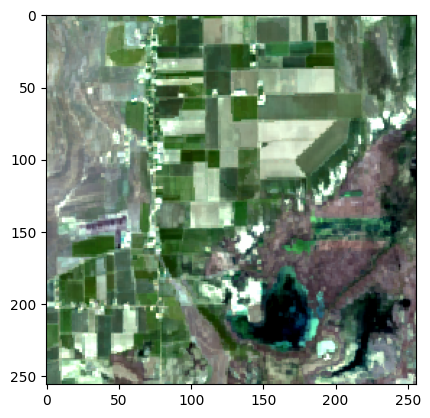

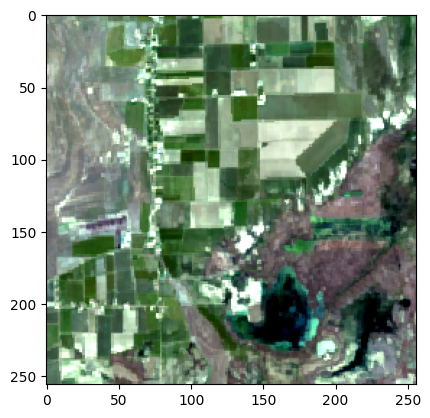

(1, 256, 256, 3)


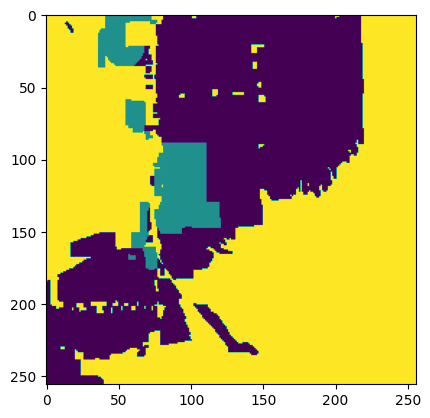

In [17]:
# print(iter(training.take(1)).next()[0])
import matplotlib.pyplot as plt
im = iter(training.take(50)).next()
arr = im[0].numpy()[0]+np.array([0.5,0.6,0.5])#This is your tensor
arr = normalize_satellite_image(arr)
# print(arr.shape)
print(np.min(arr),np.max(arr))
norm_image = cv2.normalize(arr, None, alpha = 0, beta = 1, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
plt.imshow((arr))
plt.show()
plt.imshow((norm_image))
plt.show()

arr2 = im[1]#This is your tensor
print(arr2.shape)
arr2 = np.argmax(arr2[0],axis=2)
arr_ = np.squeeze(arr2) # you can give axis attribute if you wanna squeeze in specific dimension
plt.imshow(arr_)
plt.show()


In [18]:
# # Example usage
# # image_path = 'path_to_your_dark_image.jpg'
# if is_dark_image(img):
#     img = cv2.imread(image_path)
#     adjusted_img = adjust_gamma(img, gamma=1.5)  # Adjust gamma as needed
#     cv2.imshow('Original Image', img)
#     cv2.imshow('Adjusted Image', adjusted_img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

In [ ]:
# print((arr*255).astype(np.uint8))

In [62]:
# # print(arr)

# norm_image = cv2.normalize(arr1_, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

# norm_image = norm_image.astype(np.uint8)

# print(norm_image)

In [15]:
cnt = 0
for element in training:
    cnt = cnt+1
    img = element[0].numpy()[0]+np.array([0.5,0.6,0.5])
    msk = element[1].numpy()[0]
    # img = normalize_satellite_image(img)

    norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img =  norm_image.astype(np.uint8)
    image = Image.fromarray(img)
    image.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_images/train_new/img'+ str(cnt) + '.tif', format='PNG')
    # tifffile.imwrite('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_images/train_new/img'+ str(cnt) + '.tif', img)
    # np.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_images/train_array/img'+ str(cnt) + '.npy',img)
    
    msk = np.argmax(msk,axis=2)
    msk =  msk.astype(np.uint8)
    mask = Image.fromarray(msk)
    # msk = msk[..., np.newaxis]
    # np.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_masks/train_array/msk'+ str(cnt) + '.npy', msk)
    mask.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/train_masks/train_new/msk'+ str(cnt) + '.tif', format='PNG')
    # # print(cnt, ' ', np.unique(msk[0]))
    # print(np.unique(np.argmax(msk[0],axis=2)))

In [13]:
def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{EVAL_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Evaluation'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    # dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS/4)).cache()
    dataset = dataset.map(do_not_augment_data)
    dataset = dataset.batch(1)
    return dataset

evaluation = get_eval_dataset()

print(len(list(evaluation)))

227


In [16]:
cnt = 0
for element in evaluation:
    cnt = cnt+1
    img = element[0].numpy()[0]+np.array([0.5,0.6,0.5])
    msk = element[1].numpy()[0]
    # img = normalize_satellite_image(img)

    norm_image = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    img =  norm_image.astype(np.uint8)
    image = Image.fromarray(img)
    image.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_images/val_new/img'+ str(cnt) + '.tif', format='PNG')
    # tifffile.imwrite('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_images/val_new/img'+ str(cnt) + '.tif', img)
    # np.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_images/val_array/img'+ str(cnt) + '.npy',img)

    msk = np.argmax(msk,axis=2)
    msk =  msk.astype(np.uint8)
    # msk = msk[..., np.newaxis]
    # print(msk.shape)
    mask = Image.fromarray(msk)
    mask.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_masks/val_new/msk'+ str(cnt) + '.tif', format='PNG')
    # np.save('/scratch/gza5dr/IrrigationTypeDetection/Experinments/Data/val_masks/val_array/msk'+ str(cnt) + '.npy',msk)

# My Model

In [9]:
# Load the pre-trained ResNet50 model
pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


In [24]:
# # Add a new convolutional layer with 21 channels to adapt the model for your data
# adapted_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(21, (1, 1), activation='relu', input_shape=(80, 80, 21)),
#     pretrained_model
# ])


In [25]:
# import tensorflow as tf
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Input,UpSampling2D
# from tensorflow.keras.models import Model

# # Load the ResNet50 model with pre-trained weights
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# # Choose a layer from ResNet for feature extraction
# layer_name = 'conv4_block6_out'
# base_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

# # Create the segmentation head
# def segmentation_model(input_shape,num_classes):
#     # Load the ResNet50V2 model pretrained on ImageNet
#     base_model = tf.keras.applications.ResNet50V2(input_shape=[64, 64, len(BANDS_TO_USE)],
#                                                   include_top=False,
#                                                   weights='imagenet')
    
#     # Freeze the weights of the pretrained layers
#     base_model.trainable = False
    
#     # Create a custom head for segmentation
#     x = base_model.output
#     x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#     x = UpSampling2D((4, 4))(x)
#     x = Conv2D(num_classes, (1, 1), activation='softmax')(x)
    
#     # Create the segmentation model
#     segmentation_model = Model(inputs=base_model.input, outputs=x)
#     return segmentation_model

# # Define input shape based on your data shape
# input_shape = (64, 64, 3)  # Adapted to handle 21-channel input

# # Create the segmentation model
# model = segmentation_model(input_shape=(64, 64, 3), num_classes=len(RESPONSE_TO_USE))

# # Compile the model
# model.compile(optimizer='adam', loss=LOSS, metrics=['accuracy'])

# # Get your training and evaluation datasets
# training = get_training_dataset()
# evaluation = get_eval_dataset()
# model.summary()

# # Train the model
# # model.fit(training, epochs=10, validation_data=evaluation)


In [26]:
CONVSIZE = 3 #Use 3, 5, 7, etc 3 works
DROPOUT = 0.2
DECAY_VALUE = float(1)
L1DECAY = DECAY_VALUE
L2DECAY = DECAY_VALUE
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

BNTF = True

def conv_block(input_tensor, num_filters, bnlast=False):
    if L1DECAY > 0:
        encoder = layers.Conv2D(num_filters, (CONVSIZE, CONVSIZE), padding='same', 
                            kernel_regularizer=regularizers.L1L2(l1=L1DECAY, l2=L2DECAY))(input_tensor)
    else:
        encoder = layers.Conv2D(num_filters, (CONVSIZE, CONVSIZE), padding='same')(input_tensor)
    if bnlast:
        encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Dropout(DROPOUT)(encoder)
    
    if L1DECAY > 0:
        encoder = layers.Conv2D(num_filters, (CONVSIZE, CONVSIZE), padding='same', 
                                kernel_regularizer=regularizers.L1L2(l1=L1DECAY, l2=L2DECAY))(encoder)
    else:
        encoder = layers.Conv2D(num_filters, (CONVSIZE, CONVSIZE), padding='same')(encoder)
    if bnlast:
        encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Dropout(DROPOUT)(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters, BNTF)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    if L1DECAY > 0:
        decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same', 
                                kernel_regularizer=regularizers.L1L2(l1=L1DECAY, l2=L2DECAY))(input_tensor)
    else:
        decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    if BNTF:
        decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Dropout(DROPOUT)(decoder)
    decoder = conv_block(decoder, num_filters, BNTF)
    return decoder


def get_model_light(n_neurons = 32):
    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)]) # 256  #64
    encoder0_pool, encoder0 = encoder_block(inputs, n_neurons) # 128  #32
    center = conv_block(encoder0_pool, n_neurons*2) # center
    decoder0 = decoder_block(center, encoder0, n_neurons) # 32
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

def get_model_with_resnet(n_neurons=32):
    base_model = ResNet50(weights='imagenet',include_top=False, input_shape=(64, 64, len(BANDS_TO_USE)))

    for layer in base_model.layers:
        layer.trainable = False

    inputs = layers.Input(shape=[None, None, len(BANDS_TO_USE)])
    resnet_features = base_model(inputs)
    
    encoder0_pool, encoder0 = encoder_block(resnet_features, n_neurons)
    center = conv_block(encoder0_pool, n_neurons*2)
    decoder0 = decoder_block(center, encoder0, n_neurons)
    outputs = layers.Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(decoder0)

    model = models.Model(inputs=[inputs], outputs=[outputs])

    model.compile(
        optimizer=optimizers.get(OPTIMIZER), 
        loss=losses.get(LOSS),
        metrics=[metrics.get(metric) for metric in METRICS])

    return model

# Create the model with pretrained weights
model = get_model_with_resnet(n_neurons=32)
model2 = get_model_light(n_neurons=32)


model2.summary()
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, None, None, 3 896         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, None, None, 3 128         conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_98 (Activation)      (None, None, None, 3 0           batch_normalization_70[0][0]     
___________________________________________________________________________________________

In [27]:
def print_params(model):
    total_params = 0 # initialize counter for total params
    trainable_params = 0 # initialize counter for trainable params
    print('Layer Name\t\tType\t\tFilter shape\t\t# Parameters\tTrainable') # print column headings
    for layer in model.layers: # loop over layers
        lname = layer.name # grab layer name
        ltype = type(layer).__name__ # grab layer type
        ltype[ltype.find('/'):] # parse for only the last part of the string
        if ltype=='Conv2D': # print for convolutional layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
        elif ltype=='MaxPooling2D': # print for max pool layers
            weights = layer.get_weights()
            print(lname+'\t\t'+ltype+'\t---------------\t\t---')
        elif ltype=='Flatten': # print for flatten layers
            print(lname+'\t\t'+ltype+'\t\t---------------\t\t---')
        elif ltype=='Dense': # print for dense layers
            weights = layer.get_weights()
            print(lname+'\t\t\t'+ltype+'\t\t'+str(weights[0].shape)+'\t\t'+                  str(layer.count_params())+'\t'+str(layer.trainable))
            if layer.trainable:
                trainable_params += layer.count_params()
            total_params += layer.count_params() # update number of params
    print('---------------')
    print('Total trainable parameters: '+str(trainable_params)) # print total params
    print('Total untrainable parameters: '+str(total_params-trainable_params))
    print('Total parameters: '+str(total_params))


# # Training the model
# 
# You train a Keras model by calling `.fit()` on it.  Here we're going to train for 10 epochs, which is suitable for demonstration purposes.  For production use, you probably want to optimize this parameter, for example through [hyperparamter tuning](https://cloud.google.com/ml-engine/docs/tensorflow/using-hyperparameter-tuning).

# In[39]:

model_name = 'with_resnet'

m = eval(f'get_model_{model_name}(n_neurons = 32)')

#m = get_model_64_2(n_neurons = 16)
#m = get_model_simple(n_neurons = 64)
#m = get_model_64(n_neurons = 64) ##For 64x64
#m = get_model_64_BN(n_neurons = 64) ##For 64x64
#m = get_model_deeper(n_neurons = 64)
#m = get_model_deeper_BN(n_neurons = 64)
#print_params(m)
m.summary()

# In[40]:

trainingcallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='auto', restore_best_weights=True)
NSTEPST = min(int(NYEARS*SAMPLES_PER_YEAR / BATCH_SIZE)+1, 200)
NSTEPSV =  min(int(((NYEARS*SAMPLES_PER_YEAR)/4)+1 / BATCH_SIZE), 100)
hist = m.fit(
        x=training, 
        epochs=2000, 
        steps_per_epoch=NSTEPST, 
        #steps_per_epoch=100,
        validation_data=evaluation,
        validation_steps=NSTEPSV, 
        callbacks=[trainingcallback],
        use_multiprocessing=True)


# In[ ]:
import datetime
date_str = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
print(date_str)

if len(RESPONSE_TO_USE) == 1:
    output_type = 'binary'
else:
    output_type = 'multiclass'

MODELNAME = f'Balanced_Model_Irrig_detection_{output_type}_WRLU_{len(BANDS_TO_USE)}_bands_NoCDL_{KERNEL_SIZE}x{KERNEL_SIZE}_CONVSIZE{CONVSIZE}_{date_str}_{model_name}_{int(GAUSS_NOISE_VALUE*10000)}_D{int(DECAY_VALUE*100000) if DECAY_VALUE > 0 else "NoRegu"}_BN_{"True" if BNTF else "False"}'
print(MODELNAME)
import json
def save_model_info(MODELNAME):
    m.save(filepath=os.path.join(FOLDER, MODELNAME+'.h5'), overwrite=False)
    with open(os.path.join(FOLDER, MODELNAME+'.info'),'w') as fh:
        json.dump({'BANDS':BANDS_TO_USE,'HISTORY':hist.history, 'GAUSSIAN NOISE':GAUSS_NOISE_VALUE}, fh)

save_model_info(MODELNAME)

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 2, 2, 2048)   23587712    input_29[0][0]                   
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 2, 2, 32)     589856      resnet50[0][0]                   
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 2, 2, 32)     128         conv2d_109[0][0]                 
___________________________________________________________________________________________

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[4,3] labels_size=[4096,3]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at local/scratch/oishee.hoque/12682554/ipykernel_160649/1982222884.py:56) ]] [Op:__inference_train_function_98329]

Function call stack:
train_function


## Experiment 2

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os
import tensorflow as tf
print(tf.__version__)

#tf.config.threading.set_inter_op_parallelism_threads(4)
#tf.config.threading.set_intra_op_parallelism_threads(16)

# In[34]:



# Sizes of the training and evaluation datasets.
#TRAIN_SIZE = 1703 #Use when non-ag included (does not include slope)
## Approximate total number of 32x32 areas extracted:
TOTSAMPLE = 3*(1539+1539+1569+261+114+49+105+486+177+147+203+275+282+197) #New balanced dataset is 3times as large as original 
                                                                          #N squares = number of fields /30 instead of /100
## 80% of that is training


#TRAIN_SIZE = int(TOTSAMPLE*0.8)
#TRAIN_SIZE = 16231
#TRAIN_SIZE = 3280 #Unique
#TRAIN_SIZE = 633 #Unique AOC
#TRAIN_SIZE = 894 #Unique AOC2
#TRAIN_SIZE = 682 #Unique AOC3
#TRAIN_SIZE = 1718 #Unique UT_l8_1
#TRAIN_SIZE = 2277 #Unique UT_l8_8_29_22
#TRAIN_SIZE = 3929 #Unique UT_l8_8_30_22 and 9_16_22
#TRAIN_SIZE = 3385 #non-Unique UT_l8_9_22_22
#TRAIN_SIZE = 4001 #non-Unique UT_l5_9_26_22
#TRAIN_SIZE = 7386 #non-Unique UT_l8l5_9_27_22
TRAIN_SIZE = 2000 #Per year value
#EVAL_SIZE = 395 #Use when non-ag included (does not include slope)
#EVAL_SIZE = TOTSAMPLE - TRAIN_SIZE
#EVAL_SIZE = 4100
#EVAL_SIZE = 824
#EVAL_SIZE = 144 #Unique AOC
#EVAL_SIZE = 246 #Unique AOC2
#EVAL_SIZE = 187 #Unique AOC3
#EVAL_SIZE = 383 #Unique UT_l8_1
#EVAL_SIZE = 242 #Unique UT_l8_2
#EVAL_SIZE = 498 #Unique UT_l8_8_29_22
#EVAL_SIZE = 876 #Unique UT_l8_8_30_22 and 9_16_22
#EVAL_SIZE = 842 #non-Unique UT_l8_9_22_22
#EVAL_SIZE = 966 #non-Unique UT_l5_9_26_22
#EVAL_SIZE = 1808 #non-Unique UT_l8l5_9_27_22
EVAL_SIZE = 200 #Per year value

# Specify model training parameters.
BATCH_SIZE = 64
EPOCHS = 1000 #Should auto-stop
BUFFER_SIZE = 2*(TRAIN_SIZE+BATCH_SIZE)
SAMPLES_PER_YEAR = 200
AUGMENTATION_REPEAT = 4
print(f'Estimated parameters TOTSAMPLE={TOTSAMPLE},TRAIN_SIZE={TRAIN_SIZE},EVAL_SIZE={EVAL_SIZE}, BUFFER_SIZE={BUFFER_SIZE}')


YEARS_PYTHON = ['2005', '2016']
FOLIUMLOCATION = [39.811,-111.625,]

##Input standardized Note new indices B7IND1 and B7IND2
## For Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l8_9_16_22
# ALL_BANDS = [f'BGR{i}_median' for i in range(3)]+[f'SWIR{i}_median' for i in range(3)]+[f'SR_TH_median']+\
#                 [f'BGR{i}_diff' for i in range(3)]+[f'SWIR{i}_diff' for i in range(3)]+[f'SR_TH_diff']+\
#                 [f'BGR{i}_stdDev' for i in range(3)]+[f'SWIR{i}_stdDev' for i in range(3)]+[f'SR_TH_stdDev']

ALL_BANDS = [f'BGR{i}_median' for i in range(3)]




import re
BANDS_TO_USE = ALL_BANDS

#RESPONSE = ['Drip', 'Dry Crop', 'Flood', 'Sprinkler'] #Use if drip is to be trained for
#RESPONSE = ['Dry Crop', 'Flood', 'Sprinkler'] 
#RESPONSE = ['Flood', 'Sprinkler'] 
#RESPONSE =['Irrigation']
RESPONSE = ['flood', 'sprinkler', 'other'] 
RESPONSE_TO_USE = ['flood', 'sprinkler', 'other']
#RESPONSE_TO_USE = ['sprinkler']

ALL_FEATURES = ALL_BANDS+RESPONSE
FEATURES_TO_USE = BANDS_TO_USE+RESPONSE_TO_USE

if len(RESPONSE_TO_USE) >1:
    OPTIMIZER = 'Adam'
    LOSS = 'categorical_crossentropy'
    #METRICS = ['RootMeanSquaredError']
    METRICS = ['RootMeanSquaredError', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ACTIVATION = 'softmax'
else:
    OPTIMIZER = 'Adam'
    LOSS = 'binary_crossentropy'
    #METRICS = ['RootMeanSquaredError']
    METRICS = ['RootMeanSquaredError', 'binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    ACTIVATION = 'sigmoid'



# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 64
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in ALL_FEATURES
]
COLUMNS2 = [
  tf.io.FixedLenFeature([], tf.string) for k in ALL_FEATURES
]
ALL_FEATURES_DICT = dict(zip(ALL_FEATURES, COLUMNS))
ALL_FEATURES_DICT_STRING = dict(zip(ALL_FEATURES, COLUMNS2))




# Specify names locations for outputs in Cloud Storage. 
FOLDER = '/' + 'project/nwisrl_water' + '/' + 'Irrigation_detection' + '/' + 'Irrigation_detection_lib7_4_l8l5_avg_2'
TRAINING_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_train'
EVAL_BASE = f'{KERNEL_SIZE}x{KERNEL_SIZE}_g_eval'


##Band stats



## For Irrigation_detection_WRLU_NoCDL_Balanced_Normalized_Unique_UT_l8_9_16_22



AGGREGATESTATS = {}

import numpy as np

for bname_ in ALL_FEATURES:
    if bname_ in ALL_BANDS:
        AGGREGATESTATS[bname_] = {'mean':0, 'stdDev':1,
                              'input': True,
                             'augment':True,
                                 'normalize':True}
    else:
        AGGREGATESTATS[bname_] = {'mean':0, 'stdDev':0,
                              'input': False,
                             'augment': False,
                                 'normalize':False}


print(AGGREGATESTATS)


# # Training data
# 
# Load the data exported from Earth Engine into a `tf.data.Dataset`.  The following are helper functions for that.

# In[35]:

import sys

GAUSS_NOISE_VALUE = float(0) ##Use gaussian noise values less than 1 e.g. 0.1, 0.01, etc.
# DECAY_VALUE = float(sys.argv[2])
# L1DECAY = DECAY_VALUE
# L2DECAY = DECAY_VALUE



CONVSIZE = 3 #Use 3, 5, 7, etc 3 works
DROPOUT = 0.2
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers



def parse_tfrecord(example_proto):
  """The parsing function.
  Read a serialized example into the structure defined by FEATURES_DICT.
  Args:
    example_proto: a serialized Example.
  Returns:
    A dictionary of tensors, keyed by feature name.
  """
  example_message = tf.io.parse_single_example(example_proto, ALL_FEATURES_DICT_STRING)
  features = {}
  for feature_name in example_message:
    thisfeature = example_message[feature_name]
    features[feature_name] = tf.io.parse_tensor(thisfeature, out_type=tf.float32)
        
  return features

def to_tuple(inputs):
  """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
  Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
  Args:
    inputs: A dictionary of tensors, keyed by feature name.
  Returns:
    A tuple of (inputs, outputs).
  """
  inputsList = [inputs.get(key) for key in FEATURES_TO_USE]
  
  stacked = tf.stack(inputsList, axis=0)
  # Convert from CHW to HWC
  stacked = tf.transpose(stacked, [1, 2, 0])
  return stacked

def sample_to_dict(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = {key:inputs.get(key) for key in FEATURES_TO_USE}
    return inputsList

def recenter_data(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """
    inputsList = {}
    for key in FEATURES_TO_USE:
        if key in BANDS_TO_USE:
            raw_ = inputs.get(key)
            centered_ = tf.subtract(raw_, BANDSTATS[key]['mean'])
            standardized_ = tf.divide(centered_, BANDSTATS[key]['std'])
            inputsList[key] = standardized_
        else:
            inputsList[key] = inputs.get(key)
    return inputsList


def normalize_data_(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """

    for key in BANDS_TO_USE:
        raw_ = inputs[key]
        datastd = tf.math.reduce_std(raw_)
        datamean = tf.math.reduce_mean(raw_)
        centered_ = tf.subtract(raw_, datamean)
        standardized_ = tf.divide(centered_, datastd)
        standardized_ = tf.divide(standardized_, 3)
        standardized_ = tf.add(standardized_, 1)
        inputs[key] = standardized_

    return inputs

def normalize_data(inputs):
    """Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Args:
    inputs: A dictionary of tensors, keyed by feature name.
    Returns:
    A tuple of (inputs, outputs).
    """

    for key in BANDS_TO_USE:
        if '_diff' in key:
            raw_ = inputs[key]
            datamin = tf.math.reduce_min(raw_)
            datamax = tf.math.reduce_max(raw_)
            diff = tf.subtract(datamax, datamin)
            centered_ = tf.subtract(raw_, datamin)
            standardized_ = tf.divide(centered_, diff)
            inputs[key] = standardized_

    return inputs



import random

def soft_augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    
    augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=0, 
                                   stddev=AGGREGATESTATS[key]['stdDev']*GAUSS_NOISE_VALUE*AGGREGATESTATS[key]['augment'],
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def augment_data2(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=0, 
                                   stddev=AGGREGATESTATS[key]['stdDev']*GAUSS_NOISE_VALUE*AGGREGATESTATS[key]['input'],
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def augment_data3(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=0, 
                                   stddev=GAUSS_NOISE_VALUE*AGGREGATESTATS[key]['input'],
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

light_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    ])

radio_augmentation = tf.keras.Sequential([
    layers.GaussianNoise(GAUSS_NOISE_VALUE)])

def augment_data3_stack(augm_stack):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_stack = light_augmentation(augm_stack)
    X = augm_stack[:,:,:len(BANDS_TO_USE)]
    #mean_shift = random.uniform(-0.01,0.01)
    mean_shift = random.uniform(-GAUSS_NOISE_VALUE/10,GAUSS_NOISE_VALUE/10)
    X = tf.add(X,tf.random.normal(shape=(KERNEL_SHAPE[0],KERNEL_SHAPE[0],len(BANDS_TO_USE)), 
                                   mean=mean_shift, 
                                   stddev=GAUSS_NOISE_VALUE,
                                   dtype=tf.float32))
    #X = radio_augmentation(X, training=True)
    Y = augm_stack[:,:,len(BANDS_TO_USE):]
    return X, Y

geometry_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.3, fill_mode='reflect', fill_value=0, interpolation = 'nearest'),
    layers.RandomRotation(0.4, fill_mode='reflect', fill_value=0, interpolation = 'nearest'),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='reflect', fill_value=0, interpolation = 'nearest'),
   
  ])

def augment_data3_init(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = geometry_augmentation(augm_stack)
    #augm_stack = tf.image.random_flip_left_right(augm_stack)
    #augm_stack = tf.image.random_flip_up_down(augm_stack)
    
    return augm_stack






def augment_data_not_indices(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=0, 
                                   stddev=GAUSS_NOISE_VALUE*AGGREGATESTATS[key]['augment']*AGGREGATESTATS[key]['input'],
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]


def augment_data_meanshift(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    
    augm_List = []
    for key in sample_dict:
        mean_shift = random.uniform(-GAUSS_NOISE_VALUE,GAUSS_NOISE_VALUE)
        augm_List.append(tf.add(sample_dict[key],mean_shift*AGGREGATESTATS[key]['input']))
    
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]



def hard_augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=random.uniform(-GAUSS_NOISE_VALUE,GAUSS_NOISE_VALUE)*AGGREGATESTATS[key]['input'], 
                                   stddev=AGGREGATESTATS[key]['input']*GAUSS_NOISE_VALUE,
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def hard_augment_data2(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    mean_shift = random.uniform(-GAUSS_NOISE_VALUE,GAUSS_NOISE_VALUE)
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=mean_shift*AGGREGATESTATS[key]['input'], 
                                   stddev=AGGREGATESTATS[key]['input']*GAUSS_NOISE_VALUE,
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def hard_augment_data3(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    mean_shift = random.uniform(-0.01,0.01)
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=mean_shift*AGGREGATESTATS[key]['input'], 
                                   stddev=AGGREGATESTATS[key]['input']*GAUSS_NOISE_VALUE,
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def hard_augment_data4(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [tf.add(sample_dict[key],tf.random.normal(shape=KERNEL_SHAPE, 
                                   mean=0, 
                                   stddev=AGGREGATESTATS[key]['input']*GAUSS_NOISE_VALUE,
                                   dtype=tf.float32)) for key in sample_dict]
    #augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    augm_stack = tf.image.random_flip_left_right(augm_stack)
    augm_stack = tf.image.random_flip_up_down(augm_stack)
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]

def do_not_augment_data(sample_dict):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    augm_List = [sample_dict[key] for key in sample_dict]
    augm_stack = tf.stack(augm_List, axis=0)
    augm_stack = tf.transpose(augm_stack, [1, 2, 0])
    return augm_stack[:,:,:len(BANDS_TO_USE)], augm_stack[:,:,len(BANDS_TO_USE):]    
    
def do_not_augment_stack(augm_stack):
    '''This augments the data by applying random filps 
    and adding random noise
    '''
    
    X = augm_stack[:,:,:len(BANDS_TO_USE)]
    
    Y = augm_stack[:,:,len(BANDS_TO_USE):]
    return X, Y

        

def get_dataset(fname_):
    """Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Args:
    pattern: A file pattern to match in a Cloud Storage bucket.
    Returns:
    A tf.data.Dataset
    """
    dataset = tf.data.TFRecordDataset(fname_)
    dataset = dataset.map(parse_tfrecord)
    dataset = dataset.map(sample_to_dict)
    #dataset = dataset.map(normalize_data)
    return dataset


# Use the helpers to read in the training dataset.  Print the first record to check.

# In[36]:

def get_year_data_T(fname_):
    
    dataset = get_dataset(fname_)
    #dataset = dataset.map(augment_data3_init)
    dataset = dataset.take(-1).repeat(AUGMENTATION_REPEAT).map(augment_data3_init).cache()
    dataset = dataset.shuffle(BUFFER_SIZE*AUGMENTATION_REPEAT,reshuffle_each_iteration=True).repeat()
    return dataset

def get_year_data_E(fname_):
    
    dataset = get_dataset(fname_)
    dataset = dataset.take(-1).repeat(AUGMENTATION_REPEAT).map(augment_data3_init).cache()
    dataset = dataset.shuffle(BUFFER_SIZE*AUGMENTATION_REPEAT,reshuffle_each_iteration=True).repeat()
    return dataset

    
    
YEARS = []

MINYEAR = 2003
MAXYEAR = 2022
    
    
for year in range(MINYEAR,MAXYEAR):
    if year not in [2012,2016,2017]:
        YEARS.append(year)

NYEARS = len(YEARS)


import json
Nsamples = {}
with open(os.path.join(FOLDER, 'NSamples.json'), 'r') as fh:
    Nsamples = json.load(fh)

print(f'Samples per year: {Nsamples}')
sampl_tot = {'Training':0,'Evaluation':0}
for spl in Nsamples['Training']:
    sampl_tot['Training'] += Nsamples['Training'][spl]
    sampl_tot['Evaluation'] += Nsamples['Evaluation'][spl]
NWEIGHTS = {'Training':{}, 'Evaluation':{}}
for spl in Nsamples['Training']:
    NWEIGHTS['Training'][int(spl)] = min(SAMPLES_PER_YEAR/Nsamples['Training'][spl], 1.0)
    NWEIGHTS['Evaluation'][int(spl)] = min((SAMPLES_PER_YEAR/4)/Nsamples['Evaluation'][spl], 1.0)

In [ ]:
def get_training_dataset():
    """Get the preprocessed training dataset
    Returns: 
    A tf.data.Dataset of training data.
    """
    
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{TRAINING_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Training'][year] for year in YEARS]
    datasets = [get_year_data_T(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    #dataset = dataset.take(int(SAMPLES_PER_YEAR*NYEARS)).cache()
    #dataset = dataset.shuffle(int(SAMPLES_PER_YEAR*NYEARS)*2,reshuffle_each_iteration=True).repeat()
    dataset = dataset.map(augment_data3_stack)
    dataset = dataset.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

training = get_training_dataset()

print(iter(training.take(1)).next())

In [ ]:
# # Evaluation data
# 
# Now do the same thing to get an evaluation dataset.  Note that unlike the training dataset, the evaluation dataset has a batch size of 1, is not repeated and is not shuffled.

# In[37]:


def get_eval_dataset():
    """Get the preprocessed evaluation dataset
    Returns: 
    A tf.data.Dataset of evaluation data.
    """
    
    fnames_ = [f'{FOLDER}/Proc_Samples_{year}_{EVAL_BASE}.tfrecords' for year in YEARS]
    weights = [NWEIGHTS['Evaluation'][year] for year in YEARS]
    datasets = [get_year_data_E(fname) for fname in fnames_]
    dataset = tf.data.experimental.sample_from_datasets(datasets, weights = weights)
    #dataset = dataset.take(int((SAMPLES_PER_YEAR/4)*NYEARS)).cache()
    #dataset = dataset.shuffle(int((SAMPLES_PER_YEAR/4)*NYEARS)*2,reshuffle_each_iteration=True).repeat()
    #dataset = dataset.map(augment_data3_stack)
    dataset = dataset.map(do_not_augment_stack)
    dataset = dataset.batch(batch_size=BATCH_SIZE,
                            drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    return dataset

evaluation = get_eval_dataset()

print(len(list(evaluation)))

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Choose a layer from ResNet for feature extraction
layer_name = 'conv4_block6_out'
base_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)
# Add a new convolutional layer with 21 channels to adapt the model for your data
# adapted_model = tf.keras.Sequential([
#     tf.keras.layers.Conv2D(21, (1, 1), activation='relu', input_shape=(64, 64, 21)),
#     base_model
# ])


# Create the segmentation head
def segmentation_model(input_shape):
    inputs = Input(shape=[None, None, len(BANDS_TO_USE)])
    features = base_model(inputs)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(features)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    outputs = Conv2D(len(RESPONSE_TO_USE), (1, 1), activation=ACTIVATION)(x)  # Assuming binary segmentation

    model = Model(inputs, outputs)
    return model

# Define input shape based on your data shape
input_shape = (64, 64, 21)  # Adapted to handle 21-channel input

# Create the segmentation model
model = segmentation_model(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Get your training and evaluation datasets
training = get_training_dataset()
evaluation = get_eval_dataset()

# Train the model
model.fit(training, epochs=10, validation_data=evaluation)
